In [1]:
#Import all necessary library
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
# Read the .edf file from the folder
sample_data_folder = "C:/Users/user/Desktop/New_VirpaD EEG data/New_VirpaD EEG data/03062019 1"
sample_data_raw_file = os.path.join(sample_data_folder,
                                    '03062019 1_2019.06.03_09.45.37.edf')


raw = mne.io.read_raw_edf(sample_data_raw_file, preload=True)


Extracting EDF parameters from C:\Users\user\Desktop\New_VirpaD EEG data\New_VirpaD EEG data\03062019 1\03062019 1_2019.06.03_09.45.37.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 274815  =      0.000 ...  2146.992 secs...


In [3]:
raw_temp=raw.copy() # copy the raw data for ICA implimentation
#Delete the channel that are not related to eeg signal
raw_temp.drop_channels(['COUNTER','INTERPOLATED','RAW_CQ','GYROX','GYROY','MARKER','MARKER_HARDWARE',
                       'SYNC','TIME_STAMP_s','TIME_STAMP_ms','HighBitFlex','CQ_Cz','CQ_Fz','CQ_Fp1',
                       'CQ_F7','CQ_F3','CQ_FC1','CQ_C3','CQ_FC5','CQ_FT9','CQ_T7','CQ_TP9','CQ_CP5',
                       'CQ_CP1','CQ_P3','CQ_P7','CQ_O1','CQ_Pz','CQ_Oz','CQ_O2','CQ_P8','CQ_P4','CQ_CP2',
                       'CQ_CP6','CQ_TP10','CQ_T8','CQ_FT10', 'CQ_FC6','CQ_C4','CQ_FC2','CQ_F4','CQ_F8',
                       'CQ_Fp2','CQ_CMS','CQ_DRL'])

<RawEDF  |  03062019 1_2019.06.03_09.45.37.edf, n_channels x n_times : 32 x 274816 (2147.0 sec), ~67.2 MB, data loaded>

In [4]:
# check the filtered channel
raw_temp.info["ch_names"]

['Cz',
 'Fz',
 'Fp1',
 'F7',
 'F3',
 'FC1',
 'C3',
 'FC5',
 'FT9',
 'T7',
 'TP9',
 'CP5',
 'CP1',
 'P3',
 'P7',
 'O1',
 'Pz',
 'Oz',
 'O2',
 'P8',
 'P4',
 'CP2',
 'CP6',
 'TP10',
 'T8',
 'FT10',
 'FC6',
 'C4',
 'FC2',
 'F4',
 'F8',
 'Fp2']

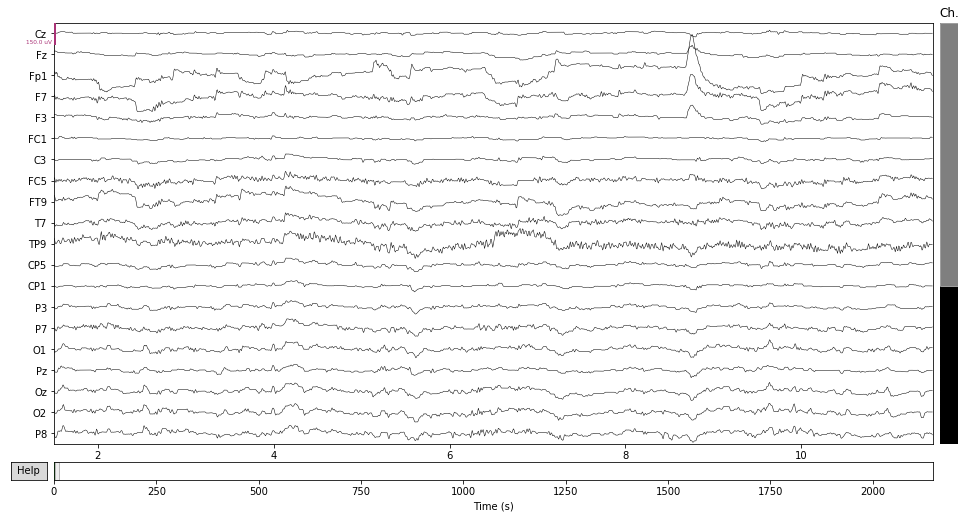

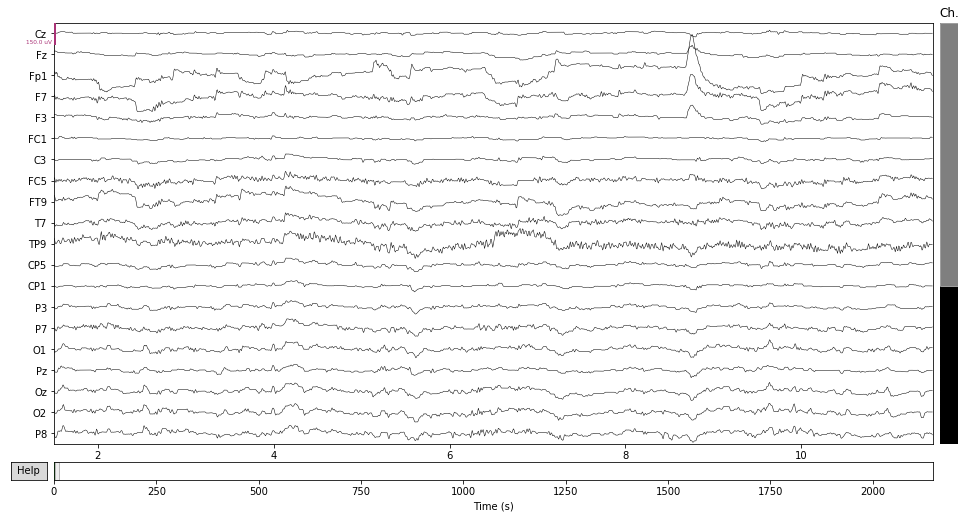

In [5]:
raw_temp.plot(start=1.5, duration=10,scalings={"eeg": 75e-6})

In [ ]:
#raw_temp.plot_psd(area_mode='range', tmax=10.0,  average=False)

Effective window size : 16.000 (s)


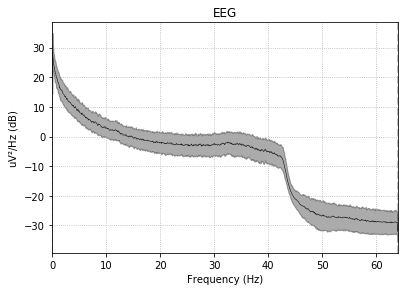

In [6]:
fig = raw_temp.plot_psd( fmax=250, average=True)#tmax=np.inf,

In [7]:
# 1Hz high pass is often helpful for fitting ICA
band = raw_temp.filter(4., 45.)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 211 samples (1.648 sec)



In [ ]:
filter_params = mne.filter.create_filter(raw_temp.get_data(), raw.info['sfreq'],
                                         l_freq=1., h_freq=50)


In [ ]:
mne.viz.plot_filter(filter_params, band.info['sfreq'], flim=(0.01, 5))

In [ ]:
raw_notch = raw_temp.copy().notch_filter(freqs=50.)

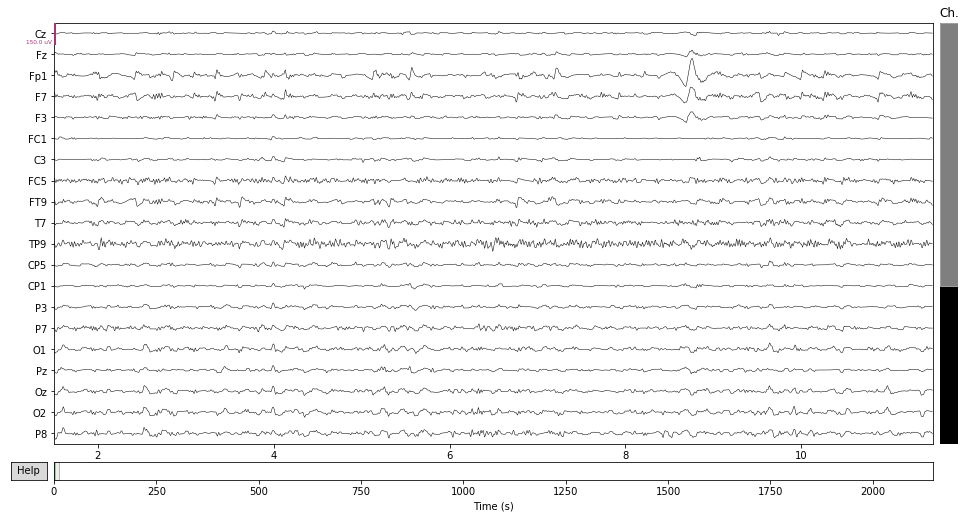

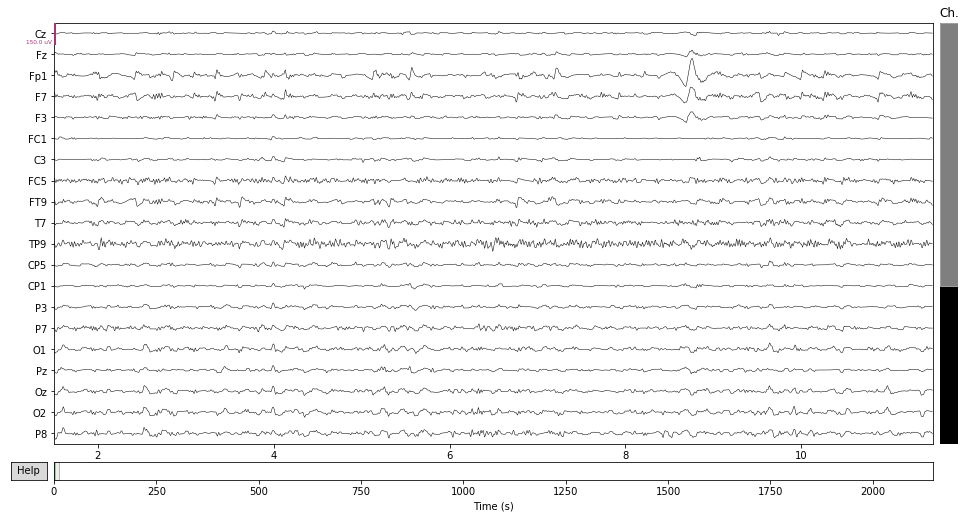

In [8]:
band.plot(start=1.5, duration=10,scalings={"eeg": 75e-6})

Effective window size : 16.000 (s)


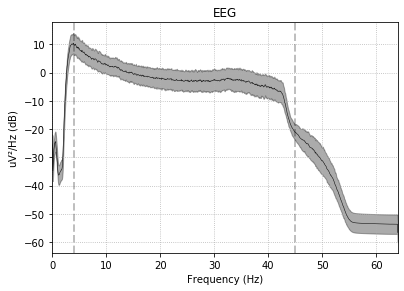

In [9]:
fig = band.plot_psd(fmax=250, average=True)

In [10]:
# set montage on filtered channel and plot it
montage = mne.channels.read_montage("standard_1020")
raw_temp.set_montage(montage)
#montage.plot()

C:\Users\user\Anaconda3\lib\site-packages\mne\utils\docs.py:830: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\user\Anaconda3\lib\site-packages\mne\utils\docs.py:813: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)
<ipython-input-10-9b3888585346>:3: DeprecationWarning: Setting a montage using anything rather than DigMontage is deprecated and will raise an error in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_dig_polhemu

<RawEDF  |  03062019 1_2019.06.03_09.45.37.edf, n_channels x n_times : 32 x 274816 (2147.0 sec), ~67.2 MB, data loaded>

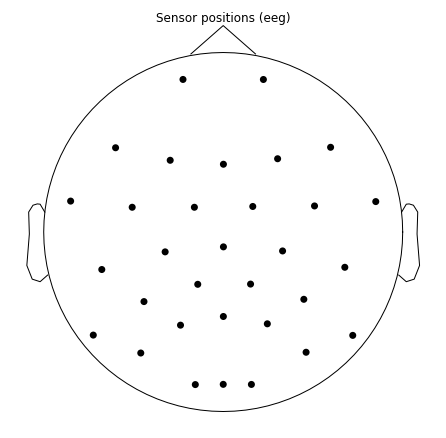

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
# check the sensors positions
fig = raw_temp.plot_sensors()
fig.show()

In [12]:
from mne.preprocessing import ICA
n_components =3 # if float, select n_components by explained variance of PCA

#set components equal to number of channels

method = 'picard'   # for comparison with EEGLAB try "extended-infomax" here
decim = 3  # we need sufficient statistics, not all time points -> saves time

# we will also set state of the random number generator - ICA is a
# non-deterministic algorithm, but we want to have the same decomposition
# and the same order of components each time this tutorial is run
random_state = 100

ica = ICA(n_components=n_components, method=method, random_state=random_state)
print(ica)

<ICA  |  no decomposition, fit (picard):  samples, no dimension reduction>


In [13]:
# fit ICA 
reject = dict(eeg=400e-6)#dict(mag=5e-12, grad=5000e-13)

ica.fit(band, picks='eeg', decim=decim,reject=reject)
print(ica)

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 3 components
Fitting ICA took 2.4s.
<ICA  |  raw data decomposition, fit (picard): 91590 samples, 3 components, channels used: "eeg">


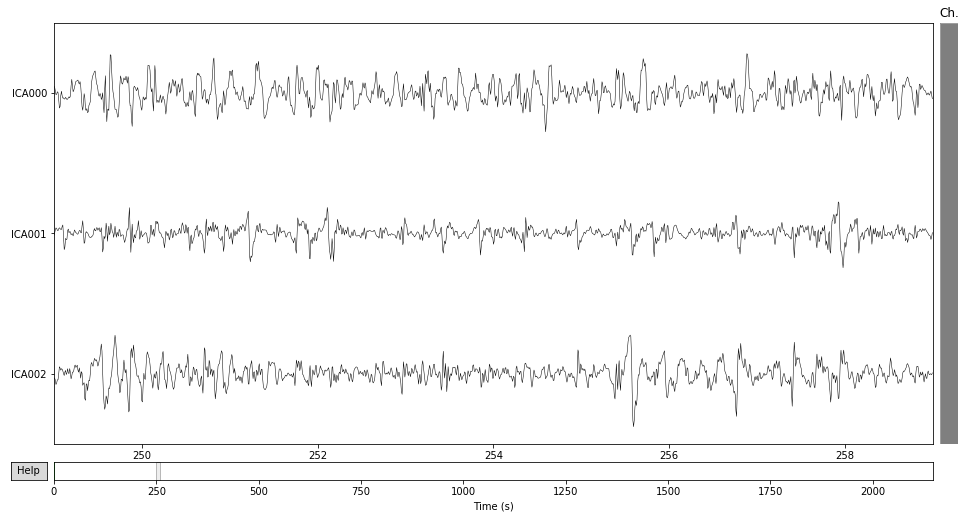

In [14]:
fig=ica.plot_sources(band,start=249,stop=259)

In [15]:
ica.detect_artifacts(band)

    Searching for artifacts...
    found 1 artifact by skewness
    found 1 artifact by kurtosis
    found 1 artifact by variance
Artifact indices found:
    1, 1, 1
    Removing duplicate indices...
Ready.


<ICA  |  raw data decomposition, fit (picard): 91590 samples, 3 components, channels used: "eeg", 1 sources marked for exclusion>

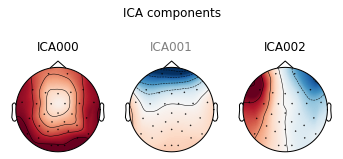

[<Figure size 352.8x180 with 3 Axes>]

In [16]:
ica.plot_components()

Creating RawArray with float64 data, n_channels=32, n_times=274688
    Range : 0 ... 274687 =      0.000 ...  2145.992 secs
Ready.
    Using multitaper spectrum estimation with 7 DPSS windows
1072 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
1072 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
1072 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


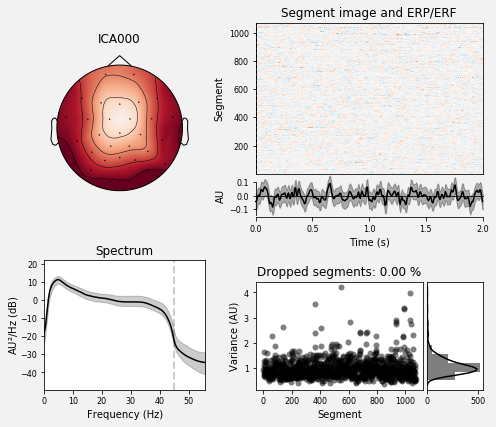

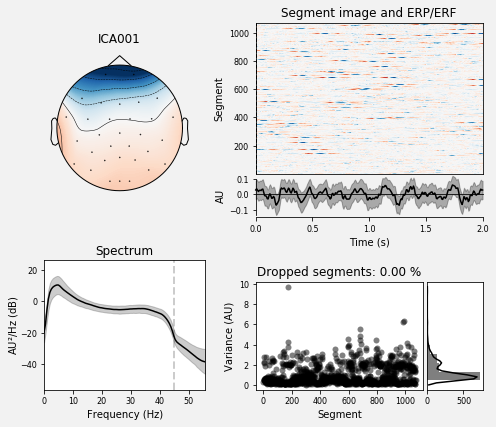

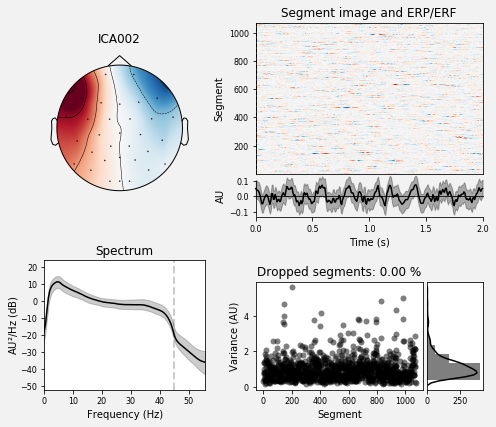

[<Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>,
 <Figure size 504x432 with 6 Axes>]

In [17]:
ica.plot_properties(raw_temp, picks=range(0,3))

In [18]:
reconst_raw = band.copy()# copy the previous data
Apply=ica.apply(reconst_raw) #apply the ICA 

Transforming to ICA space (3 components)
Zeroing out 1 ICA components


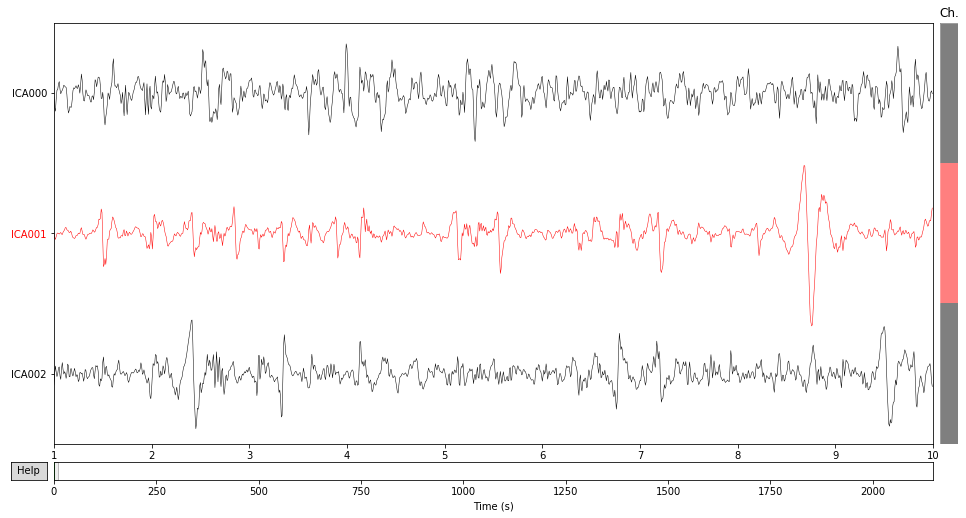

In [19]:
fig=ica.plot_sources(band,start=1,stop=10,title='ICA source from 600s')#,start=807,stop=817,

In [ ]:
picks=raw_temp.info['ch_names'][:13]
print(picks)
#ica.plot_properties(raw_temp,picks=picks)

In [ ]:
#select some forntal channel for analysis
chs_13 = ['Fz','Cz','Fp1','T7','Pz','Fp2','Oz','F8','T8','P4','O1','O2','FC5','C3','CP2']
chan_idxs = [raw_temp.ch_names.index(ch) for ch in chs_13]

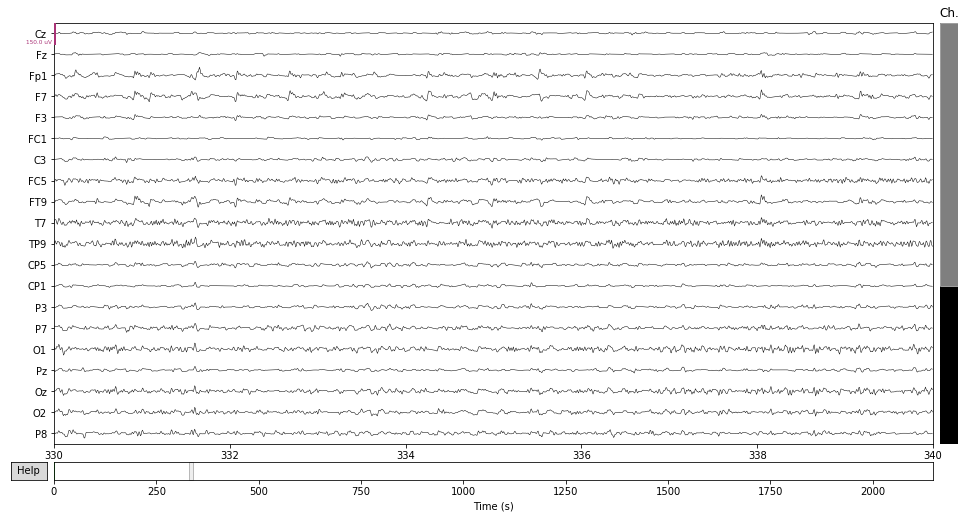

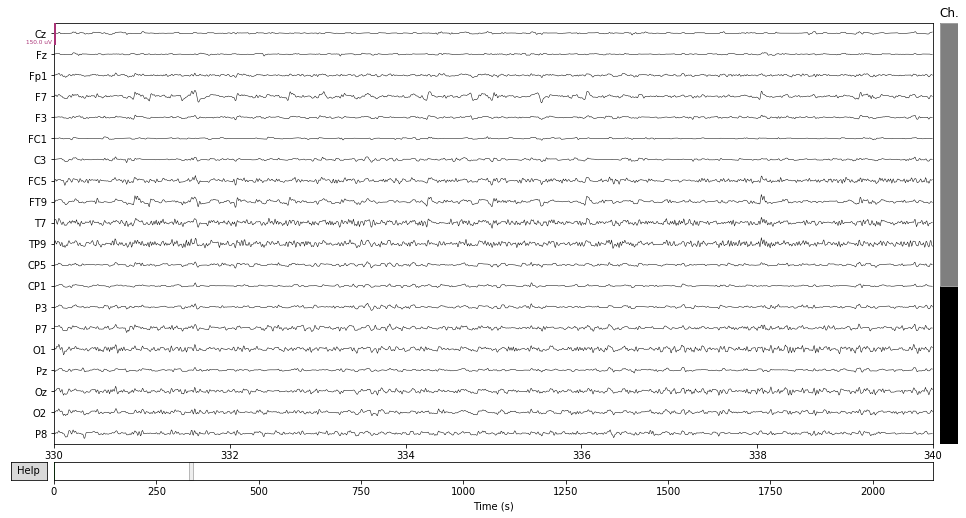

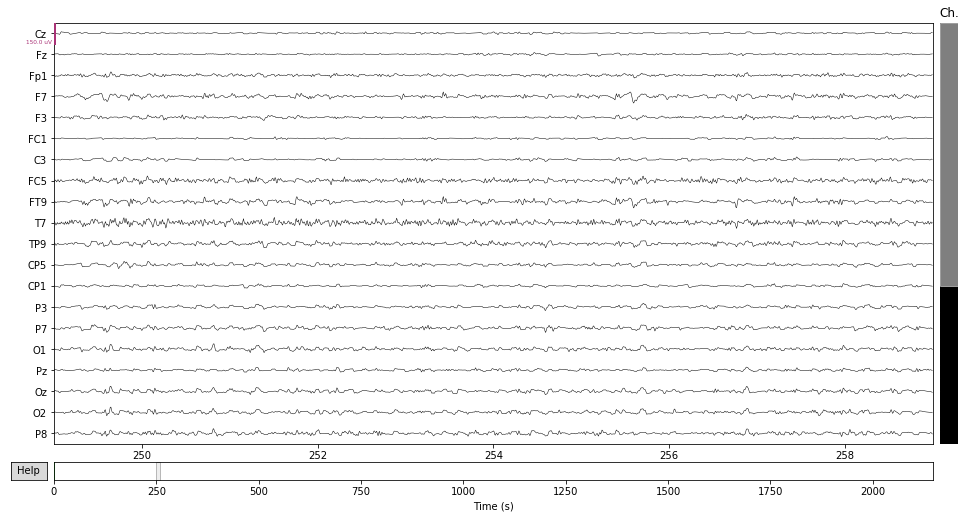

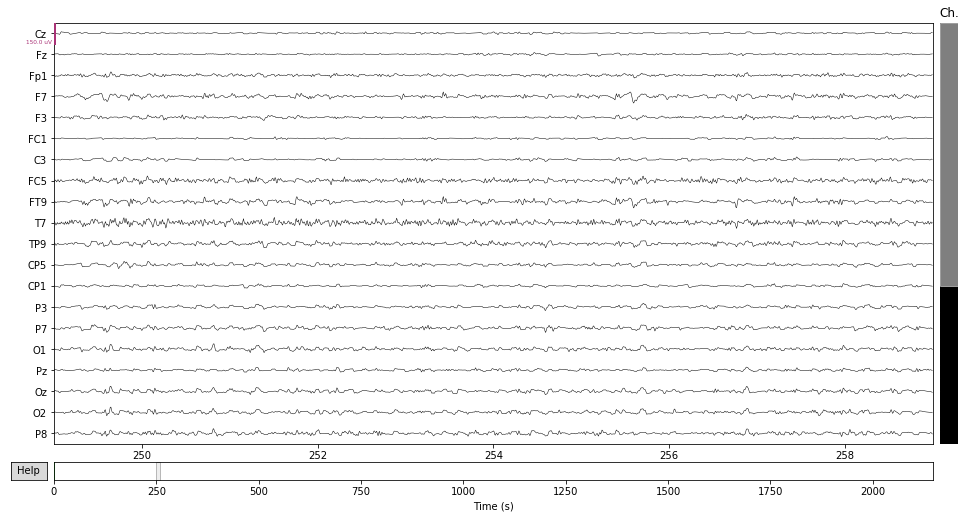

In [20]:
raw_temp.plot(start=330, duration=10,scalings={"eeg": 75e-6})
Apply.plot(start=330, duration=10,scalings={"eeg": 75e-6})
Apply.plot(start=249,duration=10,scalings={"eeg": 75e-6})

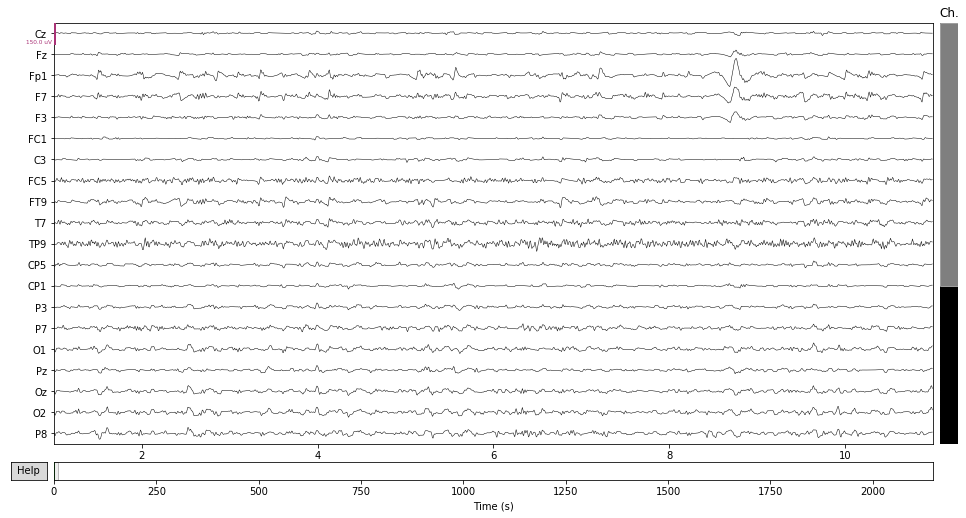

In [21]:
fig=mne.viz.plot_raw(band,start=1, duration=10,scalings={"eeg": 75e-6},title= 'before')

In [ ]:
fig=mne.viz.plot_raw(Apply,start=1, duration=20,scalings={"eeg": 75e-6},title= 'before', highpass=1., lowpass=50., filtorder=4)

Effective window size : 16.000 (s)


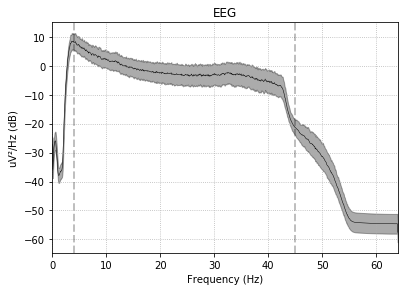

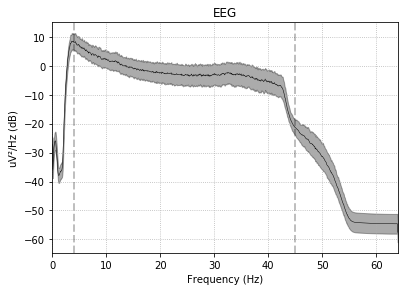

In [22]:
Apply.plot_psd(tmax=np.inf, fmax=250, average=True)#([1,4,5,6])#picks=range(1,12),

In [ ]:
Apply.plot(start=5, duration=10,scalings={"eeg": 75e-6})

In [ ]:
raw_temp.plot(start=5, duration=10,scalings={"eeg": 75e-6})

In [ ]:
Apply.plot_psd(tmax=np.inf, fmax=250,picks='eeg',average=True)#([1,4,5,6])

In [ ]:
# uncomment this for reading and writing
#Apply.save('C:/Users/user/Desktop/03062019 1.edf')
Apply.to_data_frame('C:/Users/user/Desktop/03062019 111.csv')
#raw.annotations.save('C:/Users/user/Desktop/03062019 11.csv')

In [ ]:
#Apply.plot_image(picks=['Fp1', 'Fp2'])

In [ ]:
#ica.detect_artifacts(raw_temp)

In [ ]:
#reconst_raw=raw_temp.copy()

In [ ]:
#apply=ica.apply(reconst_raw)
#apply.plot(start=979,duration=4)

In [ ]:
#raw_temp.plot(start=979,duration=4)

In [ ]:
# uncomment this for reading and writing
#Apply.save('C:/Users/user/Desktop//22052019_1_ica.edf')


In [ ]:
#from mne.preprocessing import read_ica
#read= read_ica('C:/Users/user/Desktop/doc snc/my-ica.fif')

In [ ]:
import pandas as pd

In [ ]:
path = r'C:/Users/user/Desktop/03062019 11.csv'
df = pd.read_csv(path)

In [ ]:
df